In [1]:
import torch
import numpy as np
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Dataset

In [2]:
import torchvision.datasets as data

MNIST_train = data.MNIST('./', download=True, train=True)
MNIST_test = data.MNIST('./', download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
X_train = MNIST_train.data.unsqueeze(1).float()
y_train = MNIST_train.targets
X_test = MNIST_test.data.unsqueeze(1).float()
y_test = MNIST_test.targets

tensor(5)


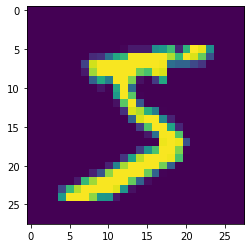

In [4]:
import matplotlib.pyplot as plt

print(y_train[0])
plt.imshow(X_train[0][0])
plt.show()

In [5]:
class Dataset():
    def __init__(self, X, Y):
        self.X_data = X
        self.y_data = Y
  
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)

In [6]:
from torch.utils.data import DataLoader

batch_size = 100
train_loader = DataLoader(Dataset(X_train, y_train), 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=2)

# Train Functions

In [7]:
def train(net, train_loader, X_test, y_test, nepoch=10):
    accuracy = lambda preds, y: (preds.argmax(dim=1) == y).float().mean()
    mean = lambda l: sum(l) / len(l)

    acc_train_hist = []
    lss_train_hist = []
    acc_test_hist = []
    lss_test_hist = []

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    print('{:<7s}|{:^20s}|{:^20s}|'.format('', 'Train', 'Test'))
    print('{:<7s}|{:>10s}{:>10s}|{:>10s}{:>10s}|'.format('Epoch', 'Loss', 'Acc', 'Loss', 'Acc'))
    print('-' * 50)

    for epoch in range(nepoch):
        net.train()

        acc_train_batch = []
        lss_train_batch = []

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = net(X_batch)
            loss_val = loss(preds, y_batch)
            loss_val.backward()
            optimizer.step()

            lss_train_batch.append(loss_val.data)
            acc_train_batch.append(accuracy(preds, y_batch))

        net.eval()
        test_preds = net.forward(X_test)

        acc_train_hist.append(mean(acc_train_batch).data.cpu())   
        lss_train_hist.append(mean(lss_train_batch).data.cpu())
        acc_test_hist.append(accuracy(test_preds, y_test).data.cpu())
        lss_test_hist.append(loss(test_preds, y_test.squeeze()).data.cpu())

        print('{:>3d}/{:>3d}|{:>10.4f}{:>10.4f}|'.format(epoch + 1, nepoch, lss_train_hist[-1], acc_train_hist[-1]), end='')
        print('{:>10.4f}{:>10.4f}|'.format(lss_test_hist[-1], acc_test_hist[-1]))

    net.eval()
    print('-' * 50)
    stats = {'TrainA': acc_train_hist,
             'TrainL': lss_train_hist,
             'TestA': acc_test_hist,
             'TestL': lss_test_hist}
    return net, stats

In [8]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def report(net, stats, X_test, y_test):
    net = net.cpu()
    preds = net.forward(X_test).argmax(dim=1).detach().numpy()
    test = y_test.detach().numpy()
    report = classification_report(test, preds)
    print(report)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
    
    ax1.plot(stats['TrainA'], label='Train Accuracy')
    ax1.plot(stats['TestA'], label='Test Accuracy')
    ax1.legend()
    
    ax2.plot(stats['TrainL'], label='Train Loss')
    ax2.plot(stats['TestL'], label='Test Loss')
    ax2.legend()

# Networks

In [36]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.actv1 = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.actv2 = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(400, 120)
        self.actv3 = torch.nn.Tanh()
        
        self.fc2 = torch.nn.Linear(120, 84)
        self.actv4 = torch.nn.Tanh()
        
        self.dp = torch.nn.Dropout(0.2)
        self.fc3 = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.pool1(x)
                
        x = self.conv2(x)
        x = self.actv2(x)
        x = self.pool2(x)
                
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.actv3(x)
        
        x = self.fc2(x)
        x = self.actv4(x)
        
        x = self.dp(x)
        x = self.fc3(x)
        return x

In [10]:
class LeNetPlus(torch.nn.Module):
    def __init__(self):
        super(LeNetPlus, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.actv1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.actv2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(400, 120)
        self.actv3 = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(120, 84)
        self.actv4 = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.actv1(x)
        x = self.pool1(x)
                
        x = self.conv2(x)
        x = self.actv2(x)
        x = self.pool2(x)
                
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.actv3(x)
        x = self.fc2(x)
        x = self.actv4(x)
        x = self.fc3(x)
        return x

In [11]:
class LeNetMax(torch.nn.Module):
    def __init__(self):
        super(LeNetMax, self).__init__()
        
        self.conv1_1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
        self.conv1_2 = torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1)
        self.actv1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2_1 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=0)
        self.conv2_2 = torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=0)
        self.actv2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(400, 120)
        self.actv3 = torch.nn.ReLU()
        
        self.fc2 = torch.nn.Linear(120, 84)
        self.actv4 = torch.nn.ReLU()
        
        self.fc3 = torch.nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.conv1_2(self.conv1_1(x))
        x = self.actv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
                
        x = self.conv2_2(self.conv2_1(x))
        x = self.actv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
                
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.actv3(x)
        x = self.fc2(x)
        x = self.actv4(x)
        x = self.fc3(x)
        return x

In [12]:
class MnistNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MnistNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(n_hidden_neurons, 10)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

# Results


## LeNet

       |       Train        |        Test        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------
  1/ 10|    0.2620    0.9277|    0.0793    0.9749|
  2/ 10|    0.0719    0.9782|    0.0561    0.9819|
  3/ 10|    0.0497    0.9848|    0.0477    0.9846|
  4/ 10|    0.0389    0.9878|    0.0476    0.9849|
  5/ 10|    0.0327    0.9896|    0.0341    0.9890|
  6/ 10|    0.0273    0.9913|    0.0481    0.9846|
  7/ 10|    0.0250    0.9917|    0.0367    0.9886|
  8/ 10|    0.0193    0.9938|    0.0379    0.9894|
  9/ 10|    0.0179    0.9940|    0.0364    0.9885|
 10/ 10|    0.0154    0.9950|    0.0361    0.9885|
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4   

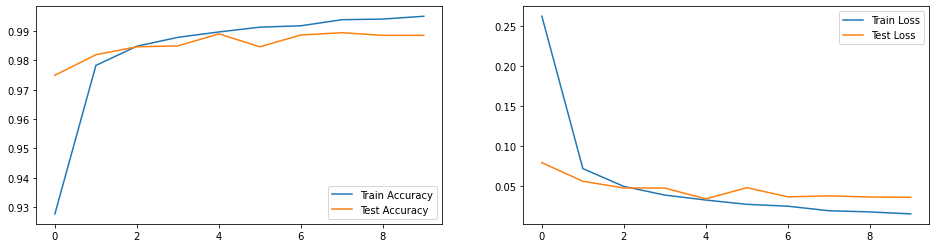

In [13]:
net, stats = train(LeNet(), train_loader, X_test, y_test, nepoch=10)
report(net, stats, X_test, y_test)

In [14]:
torch.save(net, 'LeNet.pth')

## LeNetPlus

       |       Train        |        Test        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------
  1/ 20|    0.1690    0.9473|    0.0551    0.9829|
  2/ 20|    0.0535    0.9842|    0.0494    0.9837|
  3/ 20|    0.0410    0.9867|    0.0383    0.9885|
  4/ 20|    0.0333    0.9895|    0.0396    0.9874|
  5/ 20|    0.0287    0.9907|    0.0421    0.9873|
  6/ 20|    0.0244    0.9923|    0.0459    0.9860|
  7/ 20|    0.0221    0.9929|    0.0400    0.9896|
  8/ 20|    0.0222    0.9927|    0.0377    0.9896|
  9/ 20|    0.0180    0.9943|    0.0461    0.9887|
 10/ 20|    0.0180    0.9944|    0.0609    0.9849|
 11/ 20|    0.0171    0.9947|    0.0481    0.9881|
 12/ 20|    0.0142    0.9954|    0.0422    0.9902|
 13/ 20|    0.0183    0.9945|    0.0450    0.9887|
 14/ 20|    0.0117    0.9965|    0.0488    0.9896|
 15/ 20|    0.0144    0.9955|    0.0601    0.9864|
 16/ 20|    0.0133    0.9959|    0.0441    0.9900|
 17/ 20|    0.0133    0.9960|  

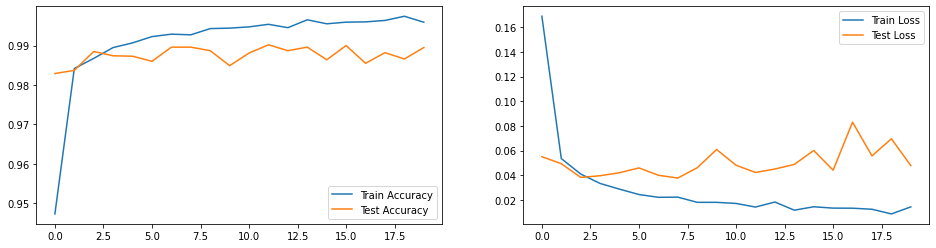

In [34]:
net, stats = train(LeNetPlus(), train_loader, X_test, y_test, nepoch=20)
report(net, stats, X_test, y_test)

In [16]:
torch.save(net, 'LeNetPlus.pth')

## LeNetMax

       |       Train        |        Test        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------
  1/ 10|    0.1419    0.9596|    0.0415    0.9859|
  2/ 10|    0.0460    0.9855|    0.0454    0.9842|
  3/ 10|    0.0318    0.9897|    0.0344    0.9887|
  4/ 10|    0.0253    0.9920|    0.0310    0.9904|
  5/ 10|    0.0217    0.9931|    0.0378    0.9884|
  6/ 10|    0.0177    0.9940|    0.0365    0.9891|
  7/ 10|    0.0149    0.9947|    0.0352    0.9907|
  8/ 10|    0.0136    0.9956|    0.0361    0.9895|
  9/ 10|    0.0136    0.9956|    0.0304    0.9907|
 10/ 10|    0.0096    0.9971|    0.0358    0.9906|
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.97      1.00      0.99      1010
           4   

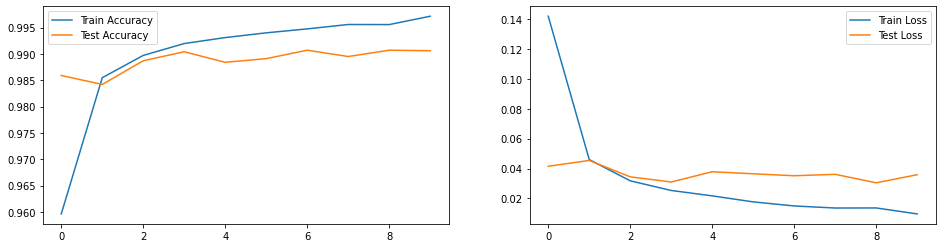

In [37]:
net, stats = train(LeNetMax(), train_loader, X_test, y_test, nepoch=10)
report(net, stats, X_test, y_test)

In [38]:
torch.save(net, 'LeNetMax.pth')

## MnistNet

In [19]:
X_train_ = X_train.reshape(-1, 28 * 28)
X_test_ = X_test.reshape(-1, 28 * 28)

train_loader_ = DataLoader(Dataset(X_train_, y_train), 
                              batch_size=batch_size, 
                              shuffle=True, 
                              num_workers=2)

       |       Train        |        Test        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------
  1/ 10|    0.3368    0.8980|    0.2581    0.9199|
  2/ 10|    0.2277    0.9305|    0.2319    0.9244|
  3/ 10|    0.2044    0.9370|    0.1901    0.9425|
  4/ 10|    0.1780    0.9439|    0.1872    0.9404|
  5/ 10|    0.1719    0.9453|    0.1697    0.9476|
  6/ 10|    0.1598    0.9502|    0.1456    0.9536|
  7/ 10|    0.1493    0.9536|    0.1408    0.9549|
  8/ 10|    0.1457    0.9534|    0.1682    0.9482|
  9/ 10|    0.1429    0.9545|    0.1573    0.9505|
 10/ 10|    0.1364    0.9568|    0.1360    0.9591|
--------------------------------------------------

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.95      0.96      0.95      1010
           4  

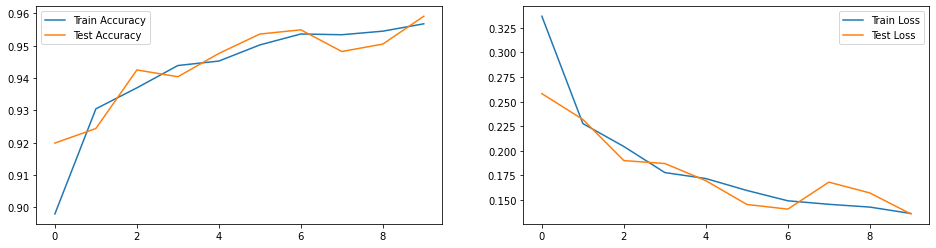

In [20]:
net, stats = train(MnistNet(28 * 28 * 4), train_loader_, X_test_, y_test, nepoch=10)
print()
report(net, stats, X_test_, y_test)

In [21]:
torch.save(net, 'MnistNet.pth')